In [ ]:
import pandas as pd
#행렬 연산 패키지
import numpy as np

#데이터 시각화
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 


In [ ]:
insu_r = pd.read_excel('C:/Users/chhch/OneDrive/Documents/POSTECH/빅데이터프로젝트/insu_request_processing.xlsx')
insu_r.head()

,customer_id,review_cat,judge,gender,age,insu_id,insu_contract_date,insu_prod_id,insu_prod_name,req_id,...,sick_3rd,dg_cat,dg_start_date,dg_end_date,dg_duration,insu_req_amount,insu_pay_amount,insu_pay_date,insu_duration,insu_cum_amount
0,C112379,혈액검사,재검,1,69,INS-10484,08-Dec-14,PR-20363,가족 만족 보험 1,C112379-20101118-12660-01-001,...,NaN,외래,24-Oct-15,16-Nov-15,24,424498,724498,18-Nov-15,11,1320000
1,C112379,혈액검사,재검,1,69,INS-10484,08-Dec-14,PR-20363,가족 만족 보험 1,C112379-20110314-17403-01-001,...,NaN,외래,17-Feb-16,17-Feb-16,1,34950,490079,13-Mar-16,15,1800000
2,C112379,혈액검사,재검,1,69,INS-10484,08-Dec-14,PR-20363,가족 만족 보험 1,C112379-20110314-17403-01-001,...,NaN,외래,24-Feb-16,24-Feb-16,1,0,490079,13-Mar-16,15,1800000
3,C112379,혈액검사,재검,1,69,INS-10484,08-Dec-14,PR-20363,가족 만족 보험 1,C112379-20110314-17403-01-001,...,NaN,외래,02-Mar-16,02-Mar-16,1,0,490079,13-Mar-16,15,1800000
4,C112379,혈액검사,재검,1,69,INS-10484,08-Dec-14,PR-20363,가족 만족 보험 1,C112379-20110314-17403-01-001,...,NaN,외래,09-Mar-16,09-Mar-16,1,16000,490079,13-Mar-16,15,1800000


In [ ]:
insu_r.shape

(42243, 24)

In [ ]:
insu_risk = pd.DataFrame(pd.read_excel('C:/Users/chhch/OneDrive/Documents/POSTECH/빅데이터프로젝트/insu_risk.xlsx'))
insu_risk.head()

,insu_prod_name,customer_id,insu_actual_expense,insu_pred_expense,insu_risk_expense,Unnamed: 5,Unnamed: 6
0,건강 보살핌,C117780,300000,494376.0,194376.0,NaN,-3.520688e+09
1,건강 보살핌,C121178,1408325,494376.0,-913949.0,NaN,NaN
2,건강 보살핌,C116605,2307750,494376.0,-1813374.0,NaN,NaN
3,건강 보살핌,C129391,4989500,494376.0,-4495124.0,NaN,NaN
4,건강 보살핌,C124954,37700,494376.0,456676.0,NaN,NaN


In [ ]:
insu_risk.shape

(4759, 7)

###  예상 - 실제 금액의 분포

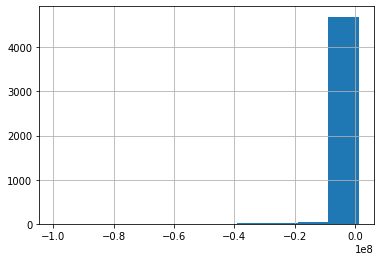

In [ ]:
# -10억이 있어서 분포가 치우쳐져있음
insu_risk['insu_risk_expense'].hist()

In [ ]:
# 이상치 개수 세는 함수
def countOutliers(x, column):
    q1 = x[column].quantile(0.25)
    q3 = x[column].quantile(0.75)
    
    iqr = 1.5 * (q3 - q1)
 
    lenOutliers = len(x[column][(x[column] > (q3 + iqr)) | (x[column] < (q1 - iqr))])
    
    return lenOutliers

def NaNOutliers(x, column):
    q1 = x[column].quantile(0.25)
    q3 = x[column].quantile(0.75)
    
    iqr = 1.5 * (q3 - q1)
 
    x[column][(x[column] > (q3 + iqr)) | (x[column] < (q1 - iqr))] = None
    
    return x[column]

NaNOutliers(insu_risk,'insu_risk_expense')

C:\Users\chhch\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0        194376.0
1       -913949.0
2      -1813374.0
3             NaN
4        456676.0
          ...    
4754   -1597780.0
4755     360300.0
4756      23083.0
4757     923361.0
4758    -472260.0
Name: insu_risk_expense, Length: 4759, dtype: float64

In [ ]:
t = insu_risk.dropna()

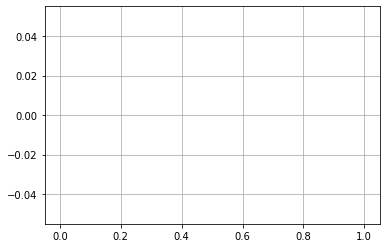

In [ ]:
# 이상치 제거 후의 분포 : 
t['insu_risk_expense'].hist()

In [ ]:
#len(insu_risk) = 4759
minus=0
plus = 0
for i in range(len(insu_risk)):
    if insu_risk['insu_risk_expense'].iloc[i] < 0 :
        minus += insu_risk['insu_risk_expense'].iloc[i]
    else:
        plus += insu_risk['insu_risk_expense'].iloc[i]


In [ ]:
print(minus + plus)


nan


[ insu_risk['insu_risk_expense']의 탐색적 분석 결과 ]
1. 이상치(-10억등)를 제외한 insu_risk_expense의 분포
2. 전체 값을 합쳤을 때 마이너스가 나옴.


# 의사결정나무

In [ ]:
#나무 구조 생성 및 저장
from sklearn.tree import export_graphviz
#나무 구조 시각화
import graphviz

#데이터 분할: train, test
from sklearn.model_selection import train_test_split
#예측/회귀 Decision test
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

from sklearn.tree import export_graphviz
#나무 구조 시각화
import graphviz
import os


os.environ['PATH'] += os.pathsep + 'C:\Program Files (x86)/Graphviz2.38/bin'

In [ ]:
model_1 = pd.read_excel('C:/Users/chhch/OneDrive/Documents/POSTECH/빅데이터프로젝트/model1_dataset_adj.xlsx')
model_1.head()

,customer_id,gender,age,bmi,waist,bp_min,bp_max,insu_risk_expense,risk
0,C117780,M,50,23.939481,83.0,85,130,-1674994.0,1
1,C121178,M,30,24.816327,86.0,80,125,-913949.0,1
2,C116605,M,50,26.259585,88.0,80,130,-1813374.0,1
3,C129391,F,35,19.227688,72.0,80,120,-4495124.0,1
4,C124954,F,55,21.457268,73.0,80,120,456676.0,0


In [ ]:
model_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4082 entries, 0 to 4081
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        4082 non-null   object 
 1   gender             4082 non-null   object 
 2   age                4082 non-null   int64  
 3   bmi                4082 non-null   float64
 4   waist              4082 non-null   float64
 5   bp_min             4082 non-null   int64  
 6   bp_max             4082 non-null   int64  
 7   insu_risk_expense  4082 non-null   float64
 8   risk               4082 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 287.1+ KB


In [ ]:
model_1 = pd.get_dummies(model_1.drop('customer_id',axis=1))

In [ ]:
# f = lambda x : 0 if x >0 else 1
# model_1['risk'] = model_1['insu_risk_expense'].apply(f)

In [ ]:
model_1.head()

,age,bmi,waist,bp_min,bp_max,insu_risk_expense,risk,gender_F,gender_M
0,50,23.939481,83.0,85,130,-1674994.0,1,0,1
1,30,24.816327,86.0,80,125,-913949.0,1,0,1
2,50,26.259585,88.0,80,130,-1813374.0,1,0,1
3,35,19.227688,72.0,80,120,-4495124.0,1,1,0
4,55,21.457268,73.0,80,120,456676.0,0,1,0


In [ ]:
model_1_y = model_1['risk']
model_1_x = model_1.drop(['insu_risk_expense','risk'], axis =1, inplace = False)

In [ ]:
df_train_x, df_test_x, df_train_y,df_test_y = train_test_split(model_1_x, model_1_y,\
                                               test_size = 0.3, random_state = 1234)

print('train data X size : {}'.format(df_train_x.shape))
print('train data Y size : {}'.format(df_train_y.shape))
print('test data X size : {}'.format(df_test_x.shape))
print('test data X size : {}'.format(df_test_y.shape))

train data X size : (2857, 7)
train data Y size : (2857,)
test data X size : (1225, 7)
test data X size : (1225,)


In [ ]:
tree_uncustomized = DecisionTreeClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

print('Score on traing set: {:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on traing set: 0.998
Score on test set: 0.513


In [ ]:
tree_uncustomized

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

In [ ]:
train_score = []; test_score=[]

para_depth = [depth for  depth in range(1,14)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(random_state = 1234, max_depth= v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth['Depth']= para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.556,0.530
1,2,0.559,0.524
2,3,0.564,0.531
3,4,0.567,0.532
4,5,0.575,0.536
5,6,0.578,0.523
6,7,0.591,0.538
7,8,0.603,0.536
8,9,0.618,0.525
9,10,0.633,0.521


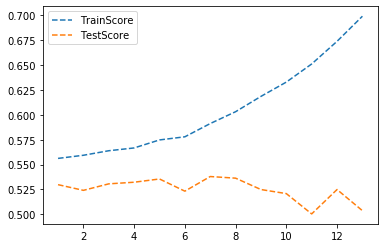

In [ ]:
plt.plot(para_depth, train_score, linestyle = '--', label = 'TrainScore' )
plt.plot(para_depth, test_score, linestyle = '--', label = 'TestScore' )
plt.legend()

max_depth=5

In [ ]:
4757*0.01

47.57

In [ ]:
train_score = []; test_score=[]

para_leaf = [n_leaf * 1 for  n_leaf in range(40,100)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(random_state = 1234, min_samples_leaf = v_min_samples_leaf,\
                                 max_depth=5)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,40,0.572,0.522
1,41,0.580,0.544
2,42,0.580,0.544
3,43,0.580,0.544
4,44,0.580,0.544
5,45,0.576,0.544
6,46,0.576,0.544
7,47,0.576,0.544
8,48,0.576,0.544
9,49,0.576,0.541


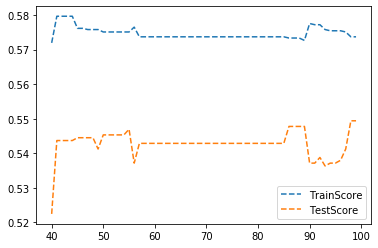

In [ ]:
plt.plot(para_leaf, train_score, linestyle = '--', label = 'TrainScore' )
plt.plot(para_leaf, test_score, linestyle = '--', label = 'TestScore' )
plt.legend()

min_samples_leaf=86

In [ ]:
train_score = []; test_score=[]

para_split = [n_split * 10 for  n_split in range(1, 11)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(random_state = 1234, min_samples_leaf =86,\
                                 min_samples_split = v_min_samples_split,max_depth=5)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,10,0.573,0.548
1,20,0.573,0.548
2,30,0.573,0.548
3,40,0.573,0.548
4,50,0.573,0.548
5,60,0.573,0.548
6,70,0.573,0.548
7,80,0.573,0.548
8,90,0.573,0.548
9,100,0.573,0.548


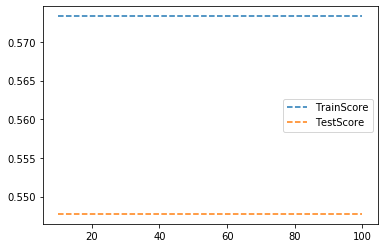

In [ ]:
plt.plot(para_split, train_score, linestyle = '--', label = 'TrainScore' )
plt.plot(para_split, test_score, linestyle = '--', label = 'TestScore' )
plt.legend()

min_samples_split=default

In [ ]:
tree_final = DecisionTreeClassifier(min_samples_leaf = 86, max_depth = 5, random_state = 1234)
tree_final.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(tree_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x, df_test_y)))

Score on training set: 0.573
Score on test set: 0.548


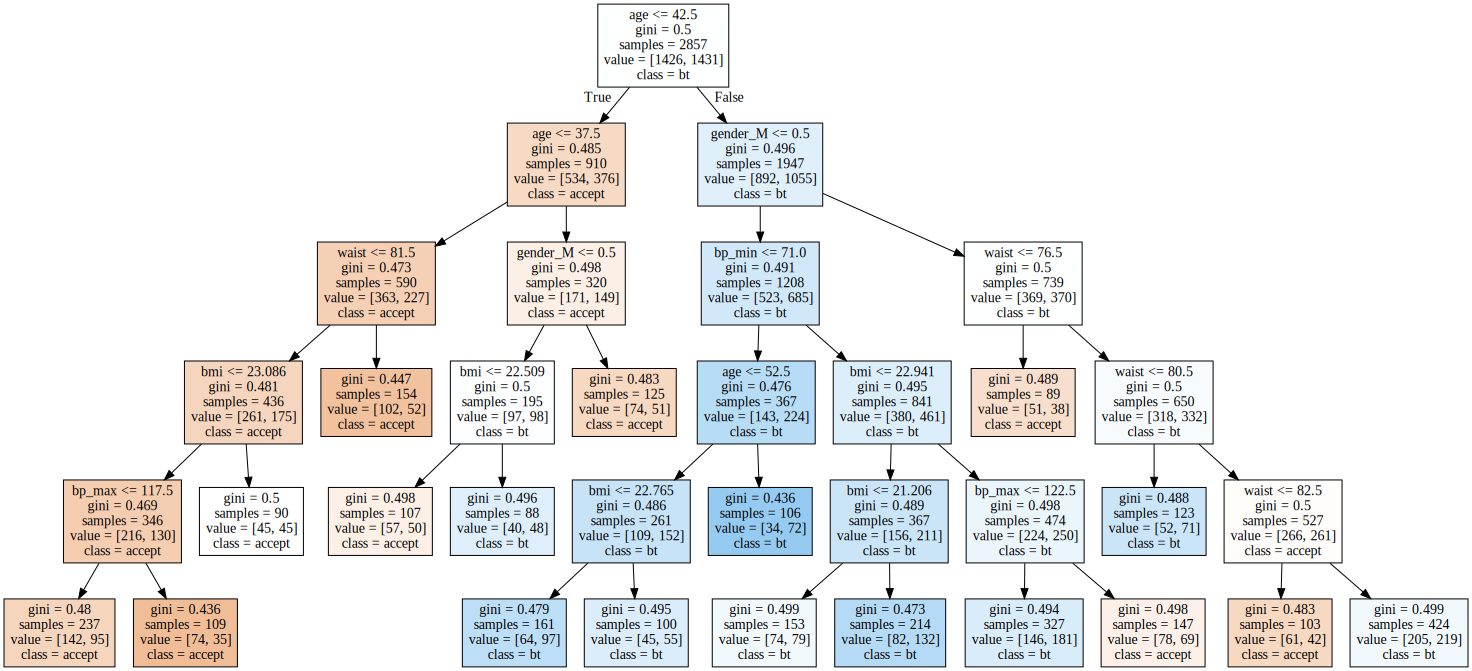

'dtree_render.png'

In [ ]:
v_feature_name = df_train_x.columns

export_graphviz(tree_final, out_file = 'tree_finalDecisionTreeClassifier.dot', class_names = ['accept','bt'],
               feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_finalDecisionTreeClassifier.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))
graph = graphviz.Source(dot_graph)
graph.format='png'
graph.render('dtree_render', view = True)

In [ ]:
y_pred = tree_final.predict(df_test_x)
y_pred

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

In [ ]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
0,age,0.541
1,bmi,0.129
6,gender_M,0.118
2,waist,0.117
4,bp_max,0.052
3,bp_min,0.043
5,gender_F,0.000


Text(0, 0.5, 'variable')

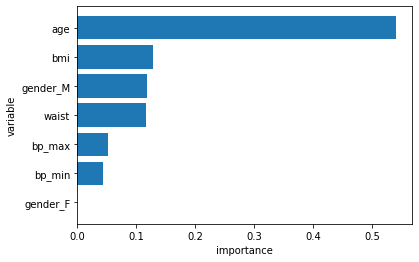

In [ ]:
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y= coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('importance')
plt.ylabel('variable')

In [ ]:
df_test_x

,age,bmi,waist,bp_min,bp_max,gender_F,gender_M
1552,55,22.837370,79.0,80,120,0,1
2770,60,22.666667,80.0,75,115,1,0
2848,55,23.634033,75.0,90,140,1,0
4040,35,20.761246,78.0,70,100,1,0
3920,40,21.671258,80.0,80,120,0,1
...,...,...,...,...,...,...,...
2240,40,27.358845,86.0,80,110,0,1
2294,55,25.711008,74.0,70,110,1,0
3111,15,20.173253,61.0,70,110,1,0
4036,45,20.932120,63.0,70,110,1,0


In [ ]:
pre_review = pd.DataFrame(pd.read_excel('C:/Users/chhch/OneDrive/Documents/POSTECH/빅데이터프로젝트/insu_pre_review_processing.xlsx', sheet_name='Sheet1'))
pre_review

,customer_id,review_cat,judge,review_date,gender,age,height,weight,bust,waist,...,bt_sgot_judge,bt_sgpt_judge,bt_trig_judge,bmi,bmi_waist_judge,age_judge,model1_judge_score,model2_judge_score,Unnamed: 53,Unnamed: 54
0,C112346,혈액검사,재검,2014-10-09,M,70,165,60,92.0,88.0,...,0.0,0.0,0.0,23.140496,0,1,2,3.0,NaN,0.788737
1,C112350,일반검진,재검,2014-11-18,M,65,175,75,99.0,92.0,...,NaN,NaN,NaN,23.671254,1,1,3,NaN,NaN,NaN
2,C112355,일반검진,재검,2015-03-18,M,70,165,65,96.0,88.0,...,NaN,NaN,NaN,24.158818,0,1,1,NaN,NaN,NaN
3,C112356,혈액검사,재검,2015-09-28,M,70,165,60,103.0,92.0,...,0.0,0.0,0.0,23.507805,1,1,2,2.0,NaN,NaN
4,C112358,혈액검사,거절,2015-02-24,M,70,165,70,100.0,91.0,...,0.0,1.0,0.0,26.491508,1,1,3,4.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14929,C134246,혈액검사,승인,2015-02-11,F,60,150,50,94.0,80.0,...,0.0,0.0,0.0,23.555556,0,1,1,1.0,NaN,NaN
14930,C134250,일반검진,승인,2015-09-16,F,50,160,60,90.0,66.0,...,NaN,NaN,NaN,22.308150,0,0,0,NaN,NaN,NaN
14931,C134251,일반검진,재검,2015-06-21,F,55,155,45,89.0,72.0,...,NaN,NaN,NaN,19.473407,0,0,0,NaN,NaN,NaN
14932,C134252,혈액검사,재검,2015-06-26,F,65,150,45,86.0,84.0,...,0.0,0.0,0.0,20.888889,0,1,2,3.0,NaN,NaN


In [ ]:
test = pre_review[['gender','age','bmi','waist','bp_min','bp_max']]

In [ ]:
test

,gender,age,bmi,waist,bp_min,bp_max
0,M,70,23.140496,88.0,80,130
1,M,65,23.671254,92.0,80,130
2,M,70,24.158818,88.0,80,120
3,M,70,23.507805,92.0,80,120
4,M,70,26.491508,91.0,85,130
...,...,...,...,...,...,...
14929,F,60,23.555556,80.0,80,120
14930,F,50,22.308150,66.0,80,120
14931,F,55,19.473407,72.0,70,110
14932,F,65,20.888889,84.0,100,150


In [ ]:
test = pd.get_dummies(test)

In [ ]:
test

,age,bmi,waist,bp_min,bp_max,gender_F,gender_M
0,70,23.140496,88.0,80,130,0,1
1,65,23.671254,92.0,80,130,0,1
2,70,24.158818,88.0,80,120,0,1
3,70,23.507805,92.0,80,120,0,1
4,70,26.491508,91.0,85,130,0,1
...,...,...,...,...,...,...,...
14929,60,23.555556,80.0,80,120,1,0
14930,50,22.308150,66.0,80,120,1,0
14931,55,19.473407,72.0,70,110,1,0
14932,65,20.888889,84.0,100,150,1,0


In [ ]:
y_pred = tree_final.predict(test)

In [ ]:
y_pred.sum()

8649

In [ ]:
a = [57, 68/(1.74**2), 77, 80, 130, 0, 1]
a= pd.DataFrame(a)
a = a.T
a

,0,1,2,3,4,5,6
0,57.0,22.460034,77.0,80.0,130.0,0.0,1.0


In [ ]:
y_pred = tree_final.predict(a)
y_pred

array([0], dtype=int64)